In [15]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, numpy as np
sn.set_context('notebook')

# ECOREG

## Analysis continued

I'm returning to this project after several months away. My [last notebook](http://nbviewer.jupyter.org/url/www.googledrive.com/host/0BximeC_RweaeVkYteXFqNE1XWXc/ecoreg_prelim_analysis.ipynb) carried out some preliminary analyses based on the IHA parameters and the PB and MZB scores calculated by Jannicke and Susi. I didn't get very far, but the analyses to date show that:

 * The IHA parameters estimated based upon 1 year of data are unreliable. More generally, the IHA methodology works best with complete water years, rather than with variable sampling dates like we have in this project. The IHA values I have already calculated using 5 years' worth of data are OK (because year boundary issues average out over longer periods), but **not all the German sites have 5 years' worth of data prior to sampling**, which is a problem. <br><br>
 
 * We have identified some weak, but statistically significant, relationships between Susi's NMDS1 and 2 scores from the ecological data and various water chemistry (TP, TOC and pH) and hydrology (90 day low flow) variables.

In this notebook I'd like to take a slightly different approach, beginning by calculating a new set of hydrological variables applicable to arbitrary time periods. I will then generate a new set of hydrological parameters for **1 year and 3 years prior to sampling**, which means we will have complete data records for all of the sites. I can then gather together all the "raw" explanatory and response variables and start to explore possible relationships.

## 1. New hydrological indicators

The code for the new hydrological indicators is quite long, so to avoid this document becoming too complicated I've moved it into a [separate notebook](https://nbviewer.jupyter.org/url/www.googledrive.com/host/0BximeC_RweaeVkYteXFqNE1XWXc/hydro_indicators_diy.ipynb). To begin with, I've calculated 35 hydrological indicators (HIs), all of which are fairly similar to the ones proposed by the IHA.

### 1.1. Absolute or relative values?

In this notebook, I've decided to work with indices based on **raw discharge values (i.e. in $m^3/s$)**, rather than on values expressed relative to the mean (as in previous notebooks). I believe the original reasons for scaling everything relative to the mean were:

 1. For many statistical techniques (e.g. PCA) it is often a good idea to "normalise" the data, otherwise the explanatory variable with the largest absolute variance ends up dominating the feature aggregation process, even if it's not very informative. <br><br>
 
 2. We already know that stream size affects ecology, and this isn't particularly interesting. By normalising, we can remove the effect of stream size and therefore look for more interesting patterns. 
 
The problem with scaling everything to the mean is that we remove the stream size component from the flow data, but not from the ecological data. We therefore still have an ecological dataset reflecting stream size variability, but we've lost the corresponding signal from the flow data and have therefore reduced our ability to explain the response. 

When it comes to PCA (and other dimensionality reduction techniques), it may ultimately be necessary to normalise the data. However, for the analysis presented here, I'd like to avoid this for as long as possible because results in "real" units are much easier to intepret from a physical perspective. Two possible alternatives for dealing with the stream size effect are:

  1. If the relationhsip between stream size and ecology is well established, we should use this relationship (e.g. from the literature) to remove the effect from *both* the flow and ecology datasets. <br><br>
  
  2. If the relationship between stream size and ecology is not well established, but turns out to be significant in our data, we should keep the raw discharge values in the model and attempt to quantify the effect. We can then then remove (i.e. "regress out") stream size and focus on exploring the patterns that are left.
  

## 2. Explanatory and response variables

The datasets to be analysed are split across several files (all in the *Stats_Input_Data* folder):

 * ***site_props.xlsx***. Names, countries and geogarphic co-ordinates for the 65 sites of interest. Latitude is likely worth including as an explanatory variable(?) <br><br>
 
 * ***hydro_indic.xlsx***. The output from my revised hydrological indicators code. This file includes data for both `pb` and `mzb` analyses and for 1 year and 3 years prior to sampling. The dataset therefore needs filtering according to the variables of interest before being joined to the others. <br><br>
 
 * ***pb_chem_ecol.xlsx***. Water chemistry plus richness and abundance scores for the `pb` sampling sites. <br><br>
 
 * ***mzb_chem_ecol.xlsx***. Water chemistry plus various ecological indices for the `mzb` sampling sites.

Note that I've done some further manual cleaning of the site codes to make everything compatible. Some Norwegian site codes in some of the files were wrong due to Excel stripping trailing zeros from the original data (e.g. S12.2 in Susi's PB data should actually be S12.200). Hopefully these issues are fixed now.

## 3. Analysis options

We have a lot of explanatory variables and also many possible choices for the ecological response. Exploring all the possible combinations, as well as considering a range of statistical methods, will therefore not be easy. A fairly obvious place to start with data like these is with Multiple Linear Regression (MLR), but there are still several choices to be made. Options include:

  1. Pick a single response variable and explore the relationships with (sub-sets of) the explanatory variables. <br><br>
  
  2. Aggregate the response variables (e.g. using PCA, NMDS etc.) and use MLR to explore the relationships with the explanatory variables. <br><br>
  
  3. Aggregate both response and explanatory variables (e.g. using PCA), and then perform MLR on the results in a comparatively low dimensional space.

With so many possible variables, aggregation techniques like PCA are certainly appealing, but they have the significant drawback of making the results much more difficult to interpret in a meaningful way. Although fiddly, **option 1 therefore seems like a good place to start**, as at least the output should have a reasonably straightforward physical interpretation.

Some other alternatives metioned in [Daniel Herring's 2006 "cook book"](http://download.springer.com/static/pdf/854/art%253A10.1007%252Fs10750-006-0087-2.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Farticle%2F10.1007%2Fs10750-006-0087-2&token2=exp=1473059931~acl=%2Fstatic%2Fpdf%2F854%2Fart%25253A10.1007%25252Fs10750-006-0087-2.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Farticle%252F10.1007%252Fs10750-006-0087-2*~hmac=e92f98416c263ded9ab852f7026e92dfcf6bca0af5a2c91974548c38f72fa0f1) include [Redundancy Analysis (RDA)](http://mb3is.megx.net/gustame/constrained-analyses/rda) and [Canonical Constrained Correspondance (CCA)](https://sites.google.com/site/mb3gustame/constrained-analyses/cca). I've not come across these before, but they seem to be popular among ecologists when analysing data of this kind. They also appear to be implemented [sci-kit-bio](http://scikit-bio.org/docs/0.4.1/generated/skbio.stats.ordination.html#module-skbio.stats.ordination), so perhaps this is something to return to later if there's time?

## 4. Read basic datasets

In [16]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

## 5. Correlation matrices

Before diving straight into MLR in a high number of dimensions, it's worth doing a bit of simple data exploration. The plots below use the (non-parametric) [Spearman's Rank Correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) to give an indication of the strength of any monotonic relationships.

### 5.1. MZB: water chemsitry and ecology

C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\seaborn\matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\seaborn\matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


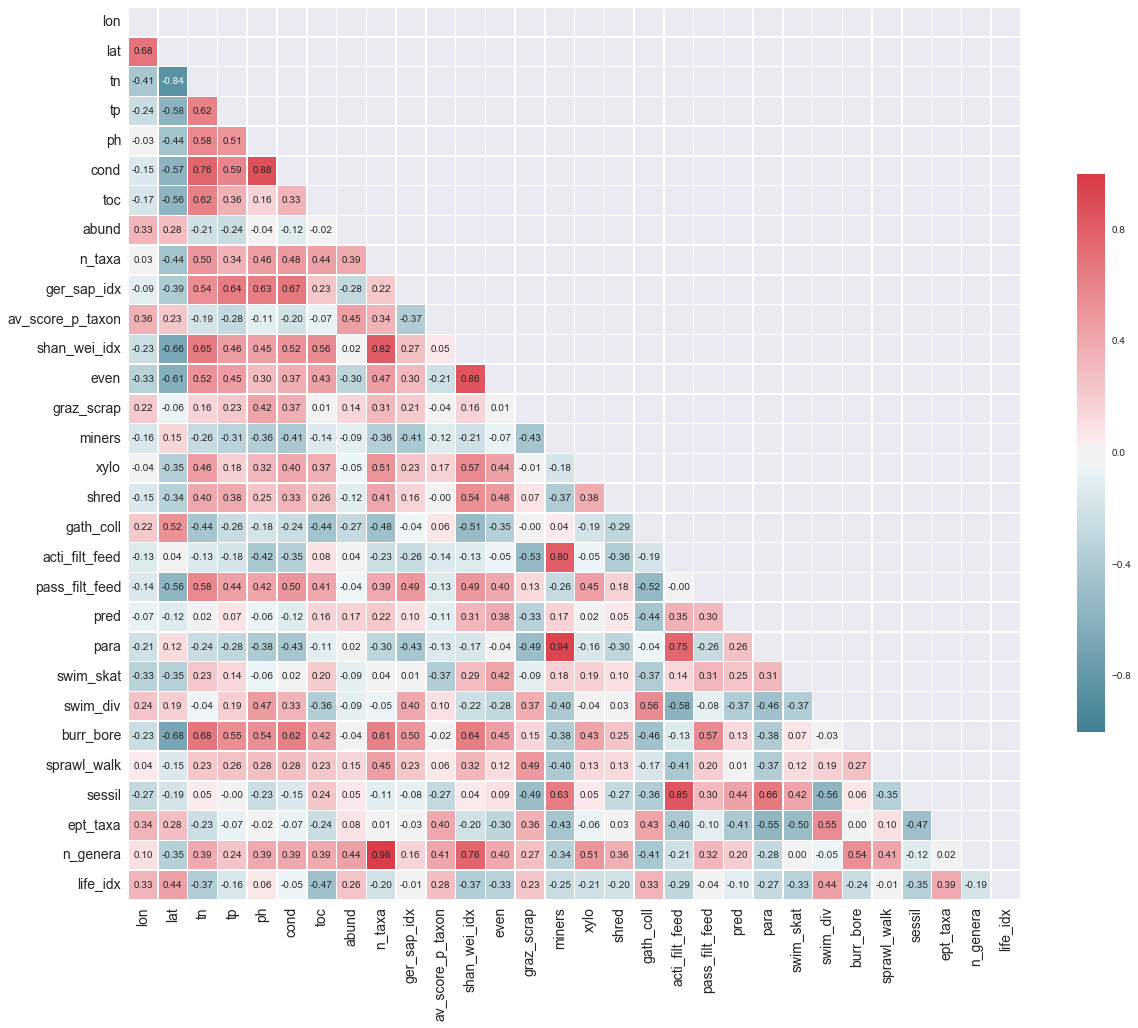

In [17]:
# Join relevant data
df = pd.concat([site_df, mzb_df], axis=1)

# Drop 4 PB sites not relevant to MZB
df.dropna(how='any', inplace=True)

# Remove unwanted cols
df.drop(['name', 'country',], axis=1, 
        inplace=True)

# Check we have the correct number of sites
assert len(df) == 61

# Calc corr matrix
corr = df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
           square=True, linewidths=.5, annot=True, 
           annot_kws={'fontsize':10}, fmt='.2f',
           cbar_kws={"shrink": .5}, ax=ax)

# Change axis label font size
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
print ''

This matrix provides an interesting view of the data, and essentially summarises the more detailed distribution-based descriptions in the [previous notebook](http://nbviewer.jupyter.org/url/www.googledrive.com/host/0BximeC_RweaeVkYteXFqNE1XWXc/ecoreg_prelim_analysis.ipynb). Most of the relationships are pretty obvious (e.g. decreasing nutrient concentrations with increasing latitude), but others are more interesting. For example, metrics such as the number of taxa, the Shannon-Wei Index, Eveness, the German Saprobic Index and even the proportion of burrowers/borers all seem positively correlated with nurients. In contrast, "abundance" seems largely uncorrelated with nutrient concentrations.

### 5.2. MZB: all metrics, 1 year before sampling

C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\seaborn\matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\seaborn\matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


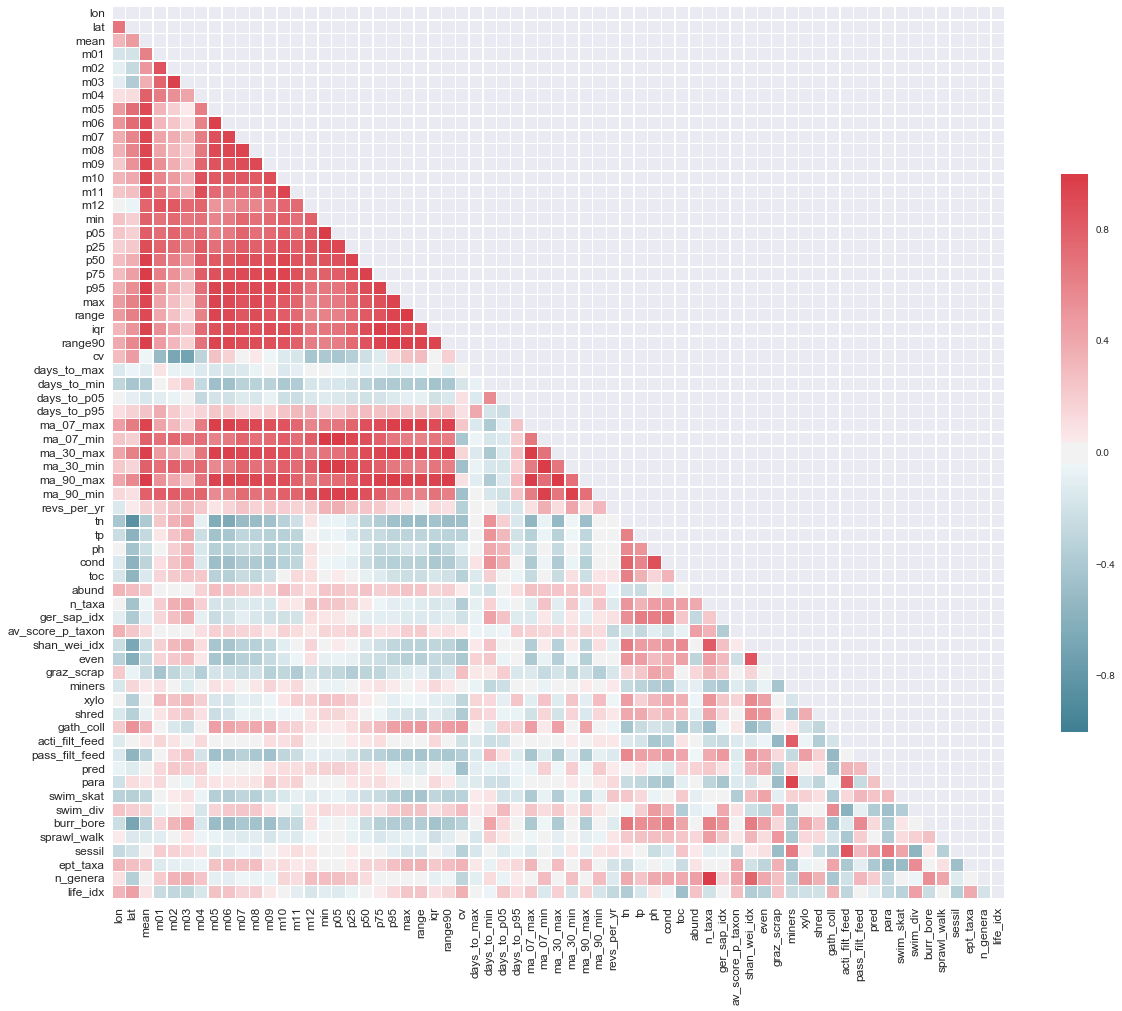

In [18]:
# Get relevant HI
mzb1_hi = hi_df.query('(eco_dataset=="mzb") & (time_per==1)')

# Join
mzb1_df = pd.concat([site_df, mzb1_hi, mzb_df], axis=1)

# Drop 4 PB sites not relevant to MZB
mzb1_df.dropna(how='any', inplace=True)

# Remove unwanted cols
mzb1_df.drop(['name', 'country', 'eco_dataset', 'time_per'], axis=1, 
             inplace=True)

# Calc corr matrix
corr = mzb1_df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
           square=True, linewidths=.5, 
           cbar_kws={"shrink": .5}, ax=ax)

# Change axis label font size
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
print ''

This matrix is a little more difficult to interpret. The triangle in the lower-right corner is identical to the one above, showing the relationships between the chemistry and ecology metrics. The triangle towards the top-left shows relationships between the hydrological metrics, and indicates that many of them are very strongly correlated indeed. This is likely to cause problems of **collinearity** in the regression analysis but, on the other hand, it also suggests that dimensionality reduction techniques such as PCA might be able to effectively simplify the hydrological signal. The rectangle forming the lower-left portion of the matrix shows relationships between the hydrological indicators and the chemistry and ecology data. Unsurprisingly, the relationships here are weaker, but these are the patterns that we're interested in and which I'd like to explore further in the subsequent analysis.

Let's plot some similar matrices for the PB data.

### 5.3. PB: water chemistry and ecology

C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\seaborn\matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\seaborn\matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


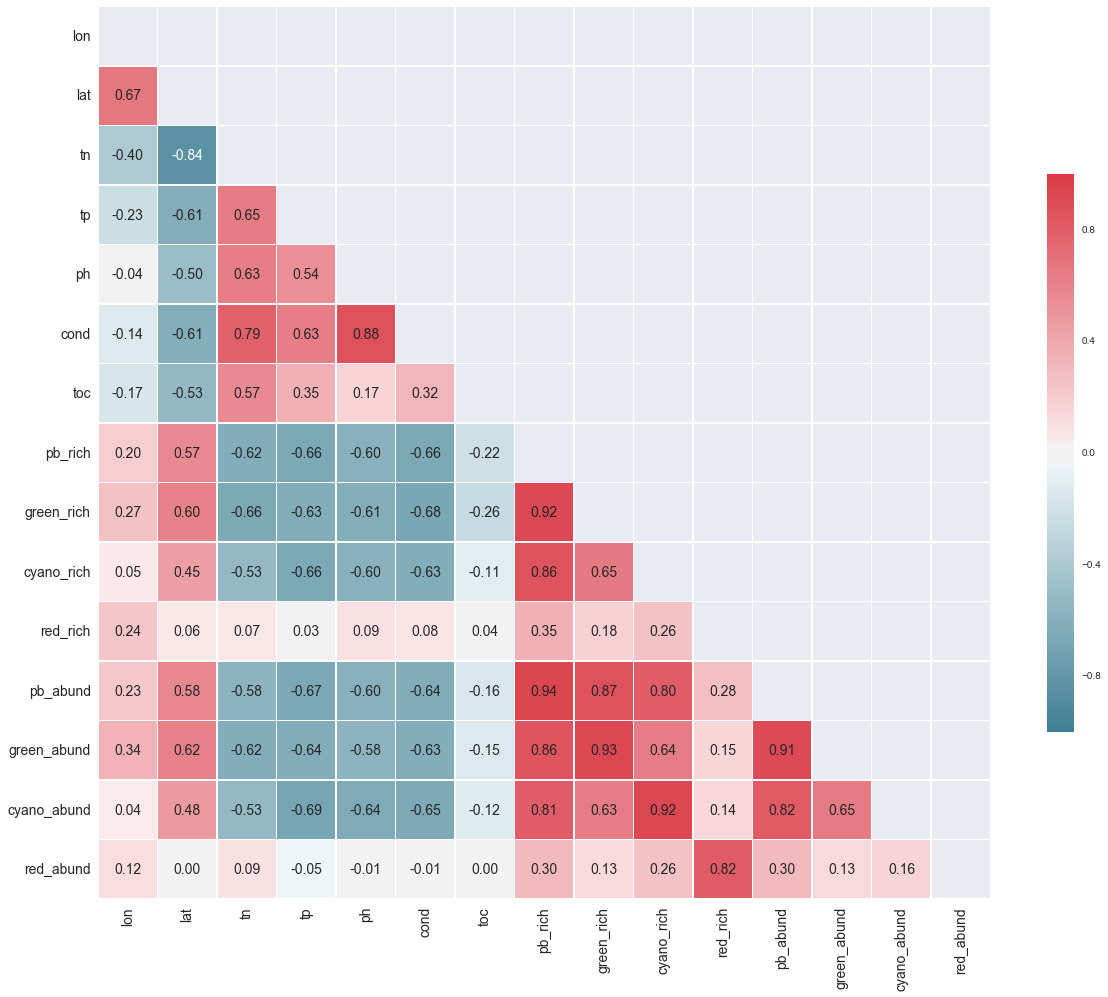

In [19]:
# Join relevant data
df = pd.concat([site_df, pb_df], axis=1)

# Drop 4 PB sites not relevant to MZB
df.dropna(how='any', inplace=True)

# Remove unwanted cols
df.drop(['name', 'country',], axis=1, 
        inplace=True)

# Check we have the correct number of sites
assert len(df) == 65

# Calc corr matrix
corr = df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
           square=True, linewidths=.5, annot=True, 
           annot_kws={'fontsize':14}, fmt='.2f',
           cbar_kws={"shrink": .5}, ax=ax)

# Change axis label font size
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=14)
print ''

As above, there is clear evidence here for decreasing nutrient concentrations with increasing latitude, and both the richness and abundance of green and blue algae species increases northwards. Similarly, it is clear that higher concentrations of N and P and/or more alkaline pH and higher conductivty, lead to decreases in both the richness and abundance of blue and green algae. Interestingly, red algae do not appear to share this response. **Is this because red algae behave differently, or just because our abundance/richness datasets for the red species are more limited?**

### 5.4. PB: all metrics, 1 year before sampling

C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\seaborn\matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\seaborn\matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


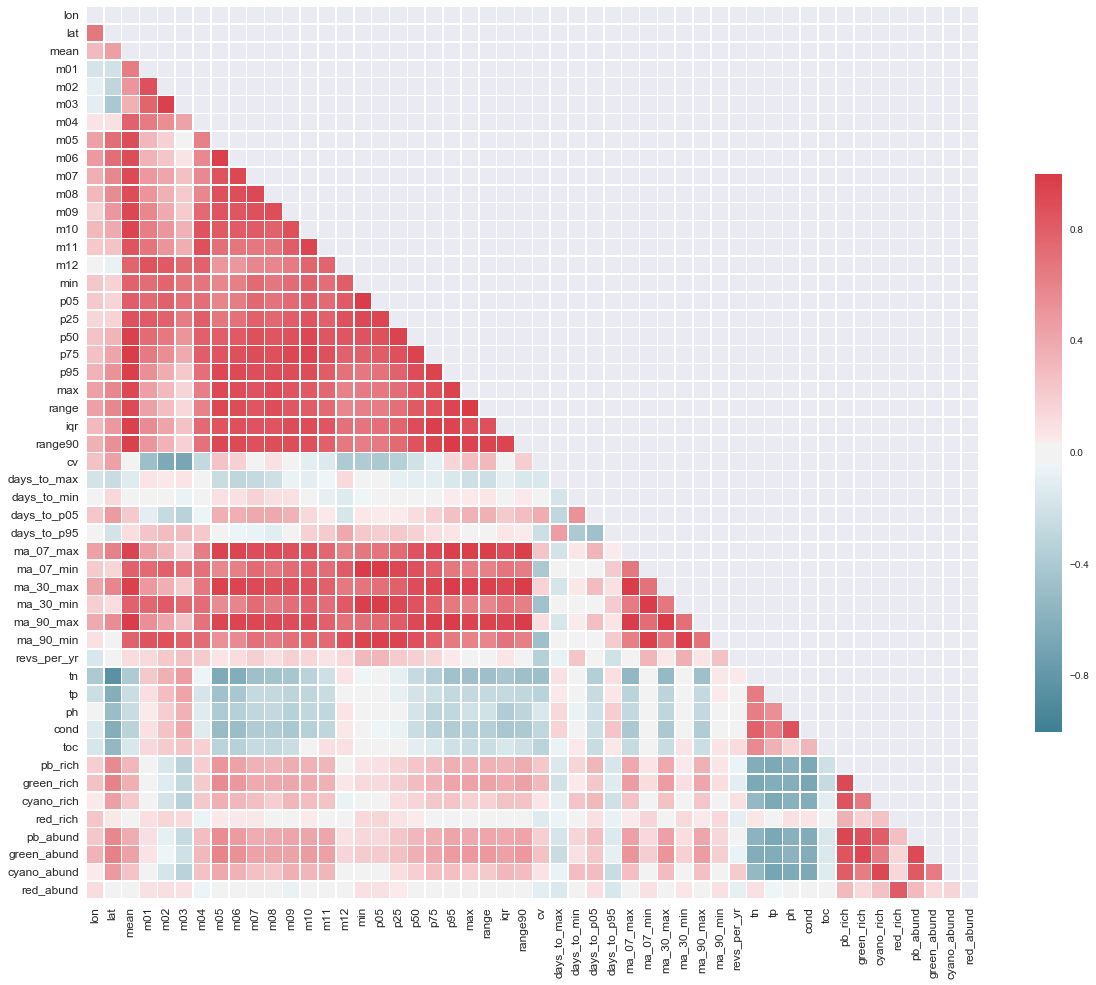

In [20]:
# Get relevant HI
pb1_hi = hi_df.query('(eco_dataset=="pb") & (time_per==1)')

# Join
pb1_df = pd.concat([site_df, pb1_hi, pb_df], axis=1)

# Drop 4 PB sites not relevant to MZB
pb1_df.dropna(how='any', inplace=True)

# Remove unwanted cols
pb1_df.drop(['name', 'country', 'eco_dataset', 'time_per'], axis=1, 
            inplace=True)
  
# Calc corr matrix
corr = pb1_df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
           square=True, linewidths=.5, 
           cbar_kws={"shrink": .5}, ax=ax)

# Change axis label font size
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
print ''

Again, latitude looks as though it could be a useful predictor here. There is also some evidence that more sustained high flows, particularly during the spring, lead to higher abundances (especially of green algae species). Whether this is due to a hydrological effect is not clear - it could simply be a consequence of Norway independently having higher algal abundances and large spring meltwater events.

## 6. Multiple linear regression

With the above matrices in mind, it's time to try some MLR. This will need doing carefully: it looks as though we have a lot of **collinear** predictors, so some kind of **penalised regression/regularisation** is likely to be appropriate. I'm no expert on this topic, but the sections below provide a brief overview.

### 6.1. Norms

A "norm" is a method for calculating the length of a vector in a vector space (or the distance between two vectors). Because they are lengths, norms must be positive, and there are many different kinds. Although seemingly abstract, norms are closely related to fundamental statistical quantities, such as the [mean, median and mode](http://www.johnmyleswhite.com/notebook/2013/03/22/modes-medians-and-means-an-unifying-perspective/). Also, because norms express distance, they can be related to goodness-of-fit in statistical models: we're interested in the "distance" between our model predictions and the observations, when expressed in some suitable vector space.

It is common to talk about $L_p$ norms, where the distance between a point (vector) $x$ and the origin is given by

$$\lVert x \rVert_p = \left(\sum_i \lvert x_i \rvert^p \right)^{(1/p)}$$

where $\lVert x \rVert_p$ is the $L_p$ norm of $x$ and $p$ is a real number. 

The $L_2$ norm ($p=2$), also known as the **Euclidean distance**, is perhaps the most common. This is the *square root of the sum of squared differences* (where the differences here are between the point and the origin)

$$\lVert x \rVert_2 = \sqrt {\left(\sum_i \lvert x_i \rvert^2 \right)}$$

OLS regression attempts to minimse the *square* of the $L_2$ norm between model predictions and observations. The objective function for OLS can therefore be written

$$min \lVert Xw - y \rVert_2^2$$

where $X$ is the matrix of explanatory variables, $w$ is a vector of parameters and $y$ is a vector of observations. In other words, OLS regression minimises the sum of squared differences.

Another common norm is the $L_1$ norm, often known as the **Manhatten distance**

$$\lVert x_i \rVert_1 = \sum_i \lvert x_i \rvert$$

The $L_1$ norm is the sum of absolute distances or, if we're thinking about differences between two data vectors, the sum of absolute errors.

In two dimensions, the difference between $L_1$ and $L_2$ norms can be illustrated as shown below:

<img src="https://www.googledrive.com/host/0BximeC_RweaeVkYteXFqNE1XWXc/norms.png" alt="norms" width="500">

The length of vector $a = (4, 3)$ using the $L_1$ norm is $(4 + 3) = 7$, whereas using the $L_2$ norm it's $\sqrt {(4^2 + 3^2)} = 5$. The $L_1$ norm is called the "Manhatten distance" because Manhatten streets are laid out on a grid, so the $L_1$ norm gives the driving distance between locations, whereas the $L_2$ norm gives the distance "as the crow flies".

### 6.2. Norms and regression

With large numbers of collinear explanatory variables, multiple linear regression using OLS becomes problematic, because parameter interactions mean many possible parameter combinations give an equally good fit to the data. In two dimensions, this can be [visualised as a "ridge"](http://stats.stackexchange.com/questions/118712/why-does-ridge-estimate-become-better-than-ols-by-adding-a-constant-to-the-diago/120073#120073) in the likelihood function over the parameter space or, equally, as a "trough" in the OLS cost function. Such models are often characterised by large parameter values, which interact with one another and cancel out. In most cases, we would like to construct a **parsimonious model**, and one way to achieve this is to modify the OLS cost function to penalise models with lots of parameters and/or very large coefficients. This can be done in a number of ways, but some common options are:

 1. **Ridge regression ($L_2$ regularisation)**. The usual OLS cost function is modifed by adding-in the $L_2$ norm of the vector of model parameters ($w$)
 
 $$min \left( \lVert Xw - y \rVert_2^2 + \alpha \lVert w \rVert_2^2 \right)$$
 
 This equation depends sensitively on the size of the parameter estimates, with parameter values closer to zero being more   likely than those further away. The overall effect is to "bend" the ends of the ridge in the likelihood surface downwards, creating a maximum where previously one did not exist. This introduces a degree of bias into the model, but often results in better out-of-sample predictive performance. $L_2$ regularisation is also particularly well-suited to cases where collinearity is expected to be a problem, or where there are more explanatory variables than data points (see e.g. [here](http://stats.stackexchange.com/questions/184019/when-will-l1-regularization-work-better-than-l2-and-vice-versa)). <br><br>
 
 2. **Lasso regression ($L_1$ regularisation)**. Ridge regression forces parameter values to be small but, because of the dependence on the *square* of the parameter values, when parameters are close to zero their effect on the likelihood surface becomes very small. For this reason, ridge regression tends to favour models with small parameter values, but it rarely actually assigns zero to any of the model coefficients i.e. ridge regression will rarely decide that a particular explanatory variable is not important and remove it from the model. 
 
 Lasso regression is a related alternative that uses the $L_1$ norm
 
  $$min \left( \frac{1}{2n} \lVert Xw - y \rVert_2^2 + \alpha \lVert w \rVert_1 \right)$$
  
  This has a similar effect (i.e. favours simpler models), but the $L_1$ penalty frequently results in assigning parameter values of zero (i.e. choosing whether a particular variable should be included or not). Lasso regression therefore tends to produce **sparse models** with as few explanatory variables as possible, and it can therefore be viewed as incorporating a form of **feature selection**.
  
  **NB:** in both cases listed above, the $\alpha$ parameter controls the degree to which model complexity is penalised. There is no simple way to set this value - it must be tuned (calibrated) using cross-validation. <br><br>
  
 3. **Elastic net regression (combines $L_1$ and $L_2$ regularisation)**. Elastic net regression modifies the OLS cost function with a combination of the $L_1$ and $L_2$ penalties. See [here](http://scikit-learn.org/stable/modules/linear_model.html#elastic-net) for an explanation of the cost function. This method provides a very flexible approach to penalised regression, where the $L_2$ (Ridge) and $L_1$ (Lasso) cases are included as end members. 

### 6.3. Implementing the MLR

The function below will allow me to explore our data using four different types of MLR: OLS, Ridge, Lasso and Elastic Net.

In [21]:
def mlr(df, exp_vars, resp_var, 
        method='ols', 
        fit_intercept=True,
        kcv=3,
        normalize=False):
    """ Performs various types of multiple linear regression.
    
    Args:
        df:            Data frame with features/responses as columns 
                       and samples as rows.
        exp_vars:      List of string specifying explanatory variables.
        resp_var:      String specifying the response variable.
        method:        'ols', 'lasso', 'ridge', 'el-net'.
        fit_intercept: Whether to fit an intercept. Default is True.
        kcv:           Number of "folds" for k-fold cross validation.
                       Default is 3.
        normalize:     Whether to normalise X before regression.
                       Default is False.
    Returns:
        A data frame of parameter estimates with (rather dodgy?)
        2-sigma error bounds and 95% significance
    """
    from sklearn import cross_validation
    from sklearn.linear_model import LinearRegression, RidgeCV
    from sklearn.linear_model import LassoCV, ElasticNetCV
    from sklearn.metrics import r2_score
    from sklearn.utils import resample 
    
    # Separate data
    X = df[exp_vars]
    y = df[resp_var]
    
    # Setup model
    if method == 'ols':
        model = LinearRegression(fit_intercept=fit_intercept, normalize=normalize)
    elif method == 'lasso':
        model = LassoCV(fit_intercept=fit_intercept, normalize=normalize, max_iter=10000)
    elif method == 'ridge':
        model = RidgeCV(fit_intercept=fit_intercept, normalize=normalize, 
                        alphas=np.logspace(-10, 10, 21))
    elif method == 'el-net':
        model = ElasticNetCV(fit_intercept=fit_intercept, normalize=normalize)
    else:
        raise ValueError('"method" parameter must be in ["ols", "lasso", "ridge", "el-net"]')
    
    # k-fold cross validation
    cv_scores = cross_validation.cross_val_score(model, X, y, cv=kcv, scoring='r2')
    print 'Mean r2 from %s-fold CV: %.3f\n' % (kcv, cv_scores.mean())
    
    # Train model on full dataset
    model.fit(X, y)
    
    # Get y-hat
    y_pred = model.predict(X)
    
    # r2 based on calibration data
    r2 = r2_score(y, y_pred)
    print 'r2 (based on the calibration data i.e. meaningless!):', r2
    print ''
    
    # Summary of model
    print model
    print ''
    
    if method == 'lasso':
        print 'Lasso alpha:', model.alpha_
        print ''
    elif method == 'ridge':
        print 'Ridge alpha:', model.alpha_
        print ''
    elif method == 'el-net':
        print 'Elastic net alpha:', model.alpha_   
        print 'Elastic net L1 ratio:', model.l1_ratio_ 
        print ''
    else: # OLS
        pass
    
    # Plot
    fig = plt.figure(figsize=(15,15))
    
    # Paired points for each site
    ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
    ax1.plot(range(0, len(X.index)), y, 'ro', label='Observed')
    ax1.plot(range(0, len(X.index)), y_pred, 'b^', label='Modelled')
    
    ax1.set_xticks(range(0, len(X.index)))
    ax1.set_xticklabels(X.index, rotation=90, fontsize=12)
    ax1.set_xlim(0, len(X.index)-1)
    
    ax1.set_xlabel('Site code', fontsize=16)
    ax1.set_ylabel(resp_var)
    ax1.set_title('Points paired for each location', fontsize=20)
    ax1.legend(loc='best', fontsize=16)
    
    # Modelled versus observed
    ax2 = plt.subplot2grid((2,2), (1,0), colspan=1)
    ax2.plot(y, y_pred, 'ro')
    ax2.set_xlabel('Observed', fontsize=16)
    ax2.set_ylabel('Modelled', fontsize=16)
    ax2.set_title('Modelled versus observed', fontsize=20)
    
    # Hist of residuals
    ax3 = plt.subplot2grid((2,2), (1,1), colspan=1)
    sn.distplot(y - y_pred, kde=True, ax=ax3)
    ax3.set_title('Histogram of residuals', fontsize=20)
    
    plt.tight_layout()
    
    # Get param estimates
    params = pd.Series(model.coef_, index=X.columns)

    # Estimate confidence using bootstrap
    # i.e. what is the std. dev. of the estimates for each parameter
    # based on 1000 resamplings
    err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 
                 axis=0)

    # Build df
    res = pd.DataFrame({'effect':params,
                        'error':2*err})

    # Rough indicator of significance: are the estimated values more than
    # 2 std. devs. from 0 (~95% CI?). NB: this assumnes the "marginal posterior"  
    # is normal, which I haven't tested for and which quite possibly isn't true
    # - use with care! 
    res['signif'] = np.abs(res['effect']) > res['error']
    
    return res

## 7. Results

I'll begin by looking at the PB data as we have more sites available (65 versus 61 for MZB) and there are also fewer ecological response variables to choose from. The **abundance** metrics in the PB dataset need handling with caution, because they're originally based on a categorical scale from 1 to 5, which Susi has cubed in order to give more meaningful "continuous" values. To keep things as straightforward as possible, I'll avoid these scores for now and instead start off by trying to model **total species richness**.

### 7.1. PB richness against water chemistry

Let's begin by attempting to predict PB richness as a linear combination of just water chemistry parameters. This shouldn't bee too complicated, so we can start with a basic OLS regression scheme.

Mean r2 from 3-fold CV: -2.995

r2 (based on the calibration data i.e. meaningless!): 0.622051472547

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)



,effect,error,signif
tn,-0.671725,2.135108,False
tp,-0.029384,0.024488,True
ph,-0.028744,3.658591,False
cond,-0.030691,0.021878,True
toc,0.625699,1.037124,False


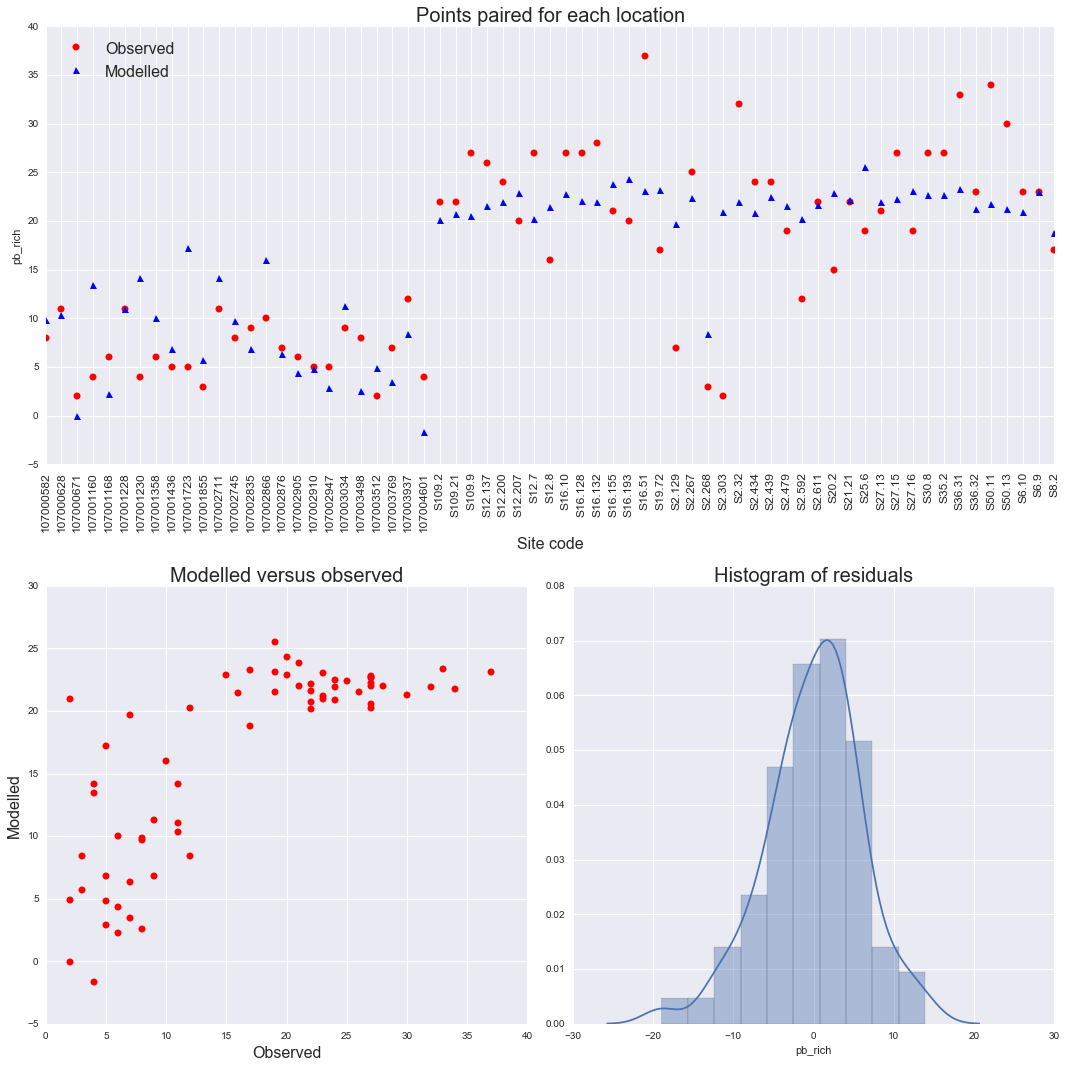

In [22]:
# Lists of explan and resp vars
exp_vars = ['tn', 'tp', 'ph', 'cond', 'toc']
resp_var = 'pb_rich'

# OLS
res = mlr(pb1_df, exp_vars, resp_var, 
          method='ols', fit_intercept=True, 
          kcv=3, normalize=False)
res

The $r^2$ based on the calibration data is 0.62, but $r^2$ based on independent cross-validation is $-3$ i.e. significantly worse than just choosing the mean. The model identifies weak but significant inverse relationships with TP and conductivity, but overall it's very poor. Interestingly, the model manages to simulate approximately the right order of variability for the German sites, but it fails to simulate the variation in Norway. This implies that Norwegian PB richness is variable *despite* relatively stable water chemistry from site to site. As a check on this, it's worth looking at the relative variability between chemical parameters for Norway versus Germany.

The image below shows box plots for TN, pH and TOC, split by country.

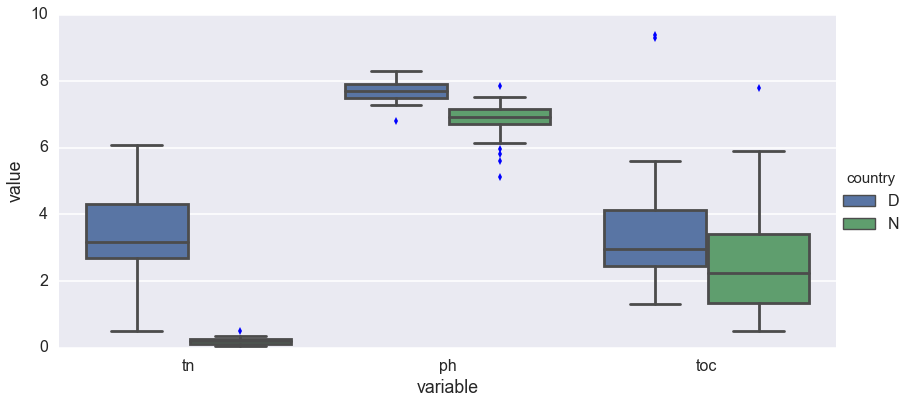

In [23]:
# Box plots for TN, pH and TOC
df = pd.concat([pb1_df, site_df], axis=1)
df = df[['country', 'tn', 'ph', 'toc']]
df = pd.melt(df, id_vars=['country'], value_vars=['tn', 'ph', 'toc'], value_name='value')

# Plot
with sn.plotting_context('poster'):
    g = sn.factorplot(x='variable', y='value', hue='country', data=df, kind='box', size=6, aspect=2)
    plt.show()

And here are the plots for TP and conductivity.

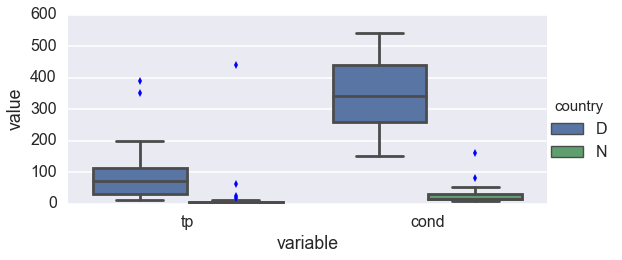

In [24]:
# Box plots for TP and cond.
df = pd.concat([pb1_df, site_df], axis=1)
df = df[['country', 'tp', 'cond']]
df = pd.melt(df, id_vars=['country'], value_vars=['tp', 'cond'], value_name='value')

# Plot
with sn.plotting_context('poster'):
    g = sn.factorplot(x='variable', y='value', hue='country', data=df, kind='box', size=4, aspect=2)
    plt.show()

In general, these plots reinforce the idea that, overall, Norwegian water chemistry is much less variable than in Germany. Nevertheless, Norwegian PB species richness is quite diverse, so **a model incorporating water chemistry variables alone cannot explain the patterns in the Norwegian data**.

Let's try a more complicated approach, throwing in all the chemistry and hydrology variables at once. I expect this will fail pretty miserably using OLS, but let's try...

### 7.2. PB richness against water chemistry and hydrology (OLS)

Mean r2 from 3-fold CV: -16410.770

r2 (based on the calibration data i.e. meaningless!): 0.844117676128

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)



,effect,error,signif
lon,-2.100491e+00,1.115214e+02,False
lat,1.734350e+00,8.266511e+01,False
mean,-2.007369e+03,2.875106e+05,False
m01,1.687813e+02,2.436457e+04,False
m02,1.536981e+02,2.212756e+04,False
m03,1.693365e+02,2.436350e+04,False
m04,1.635575e+02,2.363456e+04,False
m05,1.694770e+02,2.444157e+04,False
m06,1.639165e+02,2.364413e+04,False
m07,1.682455e+02,2.450491e+04,False


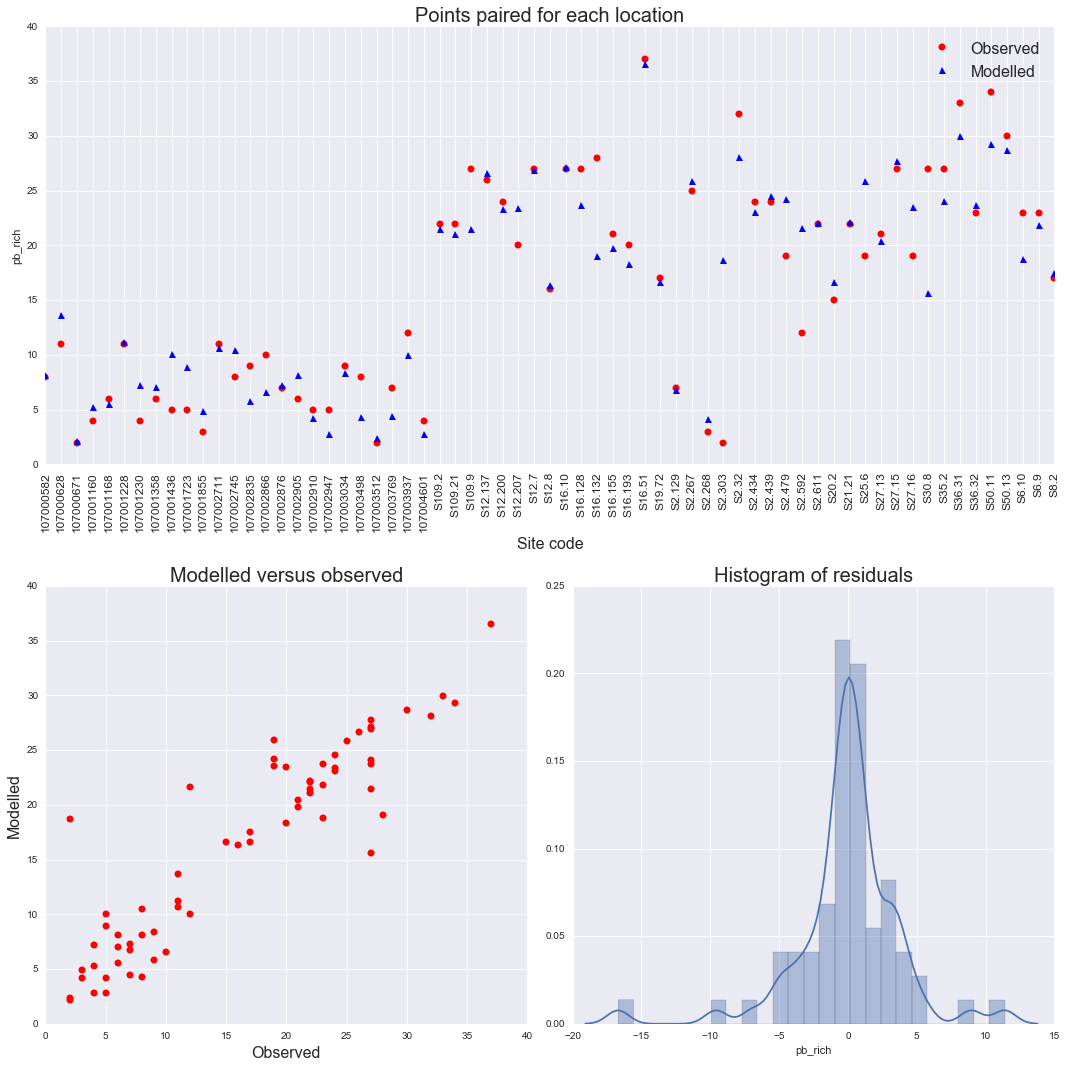

In [25]:
# Lists of explan and resp vars
exp_vars = ['lon', 'lat', 'mean', 'm01', 'm02', 'm03', 'm04', 'm05', 'm06',
            'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'min', 'p05', 'p25',
            'p50', 'p75', 'p95', 'max', 'range', 'iqr', 'range90', 'cv',
            'days_to_max', 'days_to_min', 'days_to_p05', 'days_to_p95',
            'ma_07_max', 'ma_07_min', 'ma_30_max', 'ma_30_min', 'ma_90_max',
            'ma_90_min', 'revs_per_yr', 'tn', 'tp', 'ph', 'cond', 'toc']

resp_var = 'pb_rich'

# OLS regression
res = mlr(pb1_df, exp_vars, resp_var, 
          method='ols', fit_intercept=True, 
          kcv=3, normalize=False)
res

This is a classic example of **overfitting**, which is interesting, but not for the right reasons! Note that, superficially, the model is performing well: the $r^2$ when evaluated against the calibration data is 0.84. However, independent testing using k-fold cross-validation yields an $r^2$ of $-16411$ (!), which indicates the model has essentially no predictive power. Also note that none of the coefficients are significant and some of them have huge magnitudes ($\pm 1.10^{11}$). These are exactly the problems highlighted above for OLS with large numbers of collinear parameters. The model has huge flexibility, so the parameters are able to interact and cancel out, yielding a model which fits the calibration data well but which is physically meaningless, with essentially no skill at reproducing the underlying behaviour of the system. 

Can we do better?

### 7.3. PB richness against water chemistry and hydrology (Ridge)

Mean r2 from 3-fold CV: -3.025

r2 (based on the calibration data i.e. meaningless!): 0.658884111629

RidgeCV(alphas=array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

Ridge alpha: 100000.0



,effect,error,signif
lon,-0.000128,92.084016,False
lat,0.002305,45.269486,False
mean,0.001063,42874.245005,False
m01,0.001068,3632.944124,False
m02,0.001855,3284.946115,False
m03,0.000791,3640.590076,False
m04,-0.000082,3517.078841,False
m05,0.008191,3638.508809,False
m06,-0.001802,3522.886189,False
m07,-0.002822,3642.502003,False


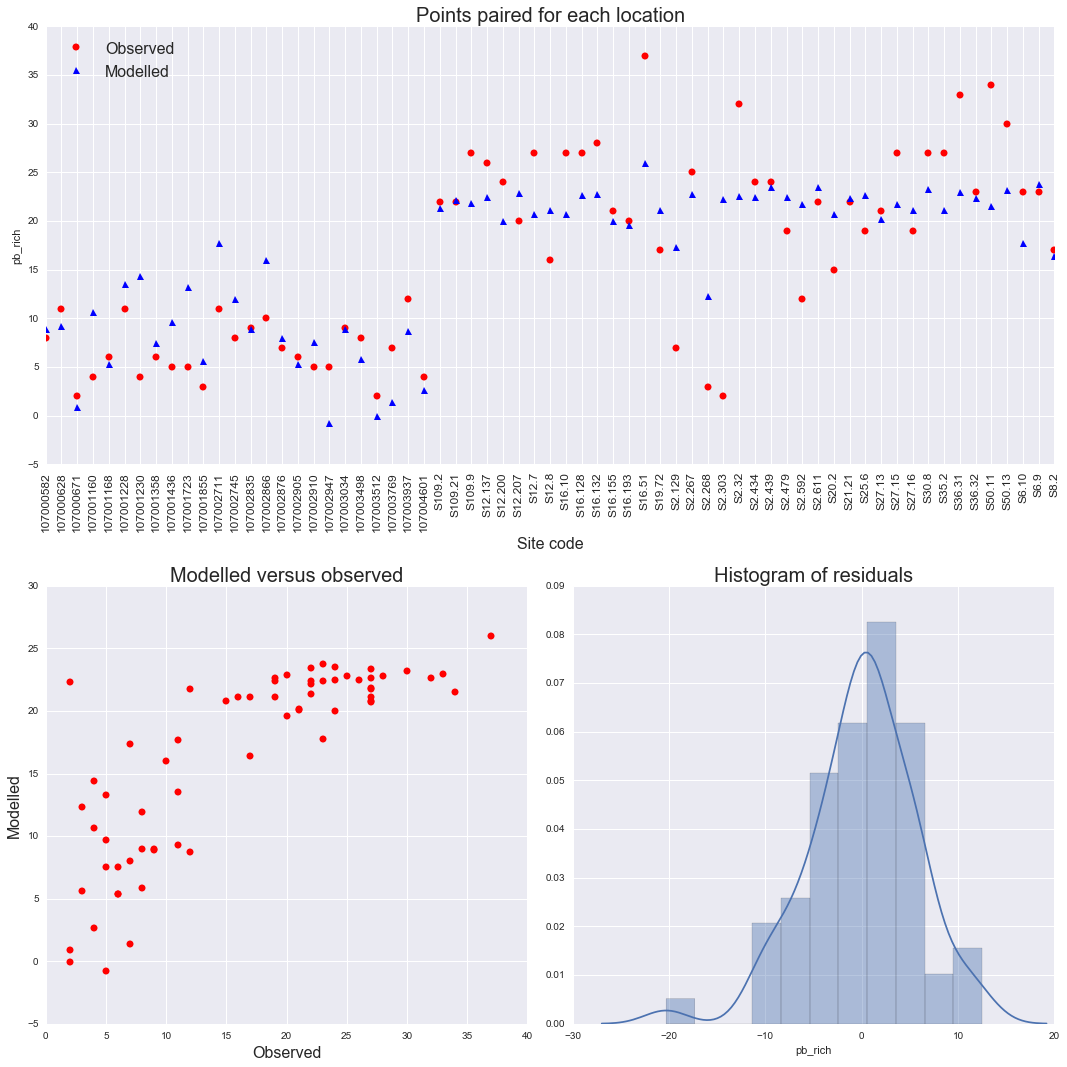

In [26]:
# Ridge regression
res = mlr(pb1_df, exp_vars, resp_var, 
          method='ridge', fit_intercept=True, 
          kcv=3, normalize=False)
res

The cross-validation $r^2$ is still poor ($-3$), but it's dramatically better than the OLS result. The superficial calibration $r^2$ is slightly worse, but this isn't a bad thing as it means the model is fitting less of the noise. The coefficients are also much smaller than before, which illustrates the effect of the $L_2$ penalty. Note, however, that the coefficients are still all insignificant. 

Looking at the top plot above, the results here are actually similar to those from the chemistry-only regression we started with: the model can fit the variability in the German data, but not at the Norwegian sites. This is surprising, because we've added a very large number of additional hydrological parameters, which don't seem to be having and effect. In fact, **the $L_2$ penalised model using all possible explanatory vaiables has very similar performance (and even parameters) to the chemistry-only model**. This implies the hydrological parameters are providing essentially no ecologically relevant information - the model is simply falling back to predicting the German PB richness based on water chemistry and failing to reproduce the Norwegian variability.

How robust is this result? Let's try skip Lasso regression and go stright to Elastic Net, which incorporates Lasso anyway as an extreme case.

### 7.4. PB richness against water chemistry and hydrology (Elastic Net)

Mean r2 from 3-fold CV: -2.570

r2 (based on the calibration data i.e. meaningless!): 0.630512807423

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

Elastic net alpha: 118.900693176
Elastic net L1 ratio: 0.5



,effect,error,signif
lon,-0.000000,0.032510,False
lat,0.000000,0.243762,False
mean,0.000000,0.000000,False
m01,0.000000,0.034799,False
m02,0.000000,0.038424,False
m03,0.000000,0.025667,False
m04,0.000000,0.043776,False
m05,0.000000,0.154954,False
m06,0.000000,0.132463,False
m07,-0.000000,0.058231,False


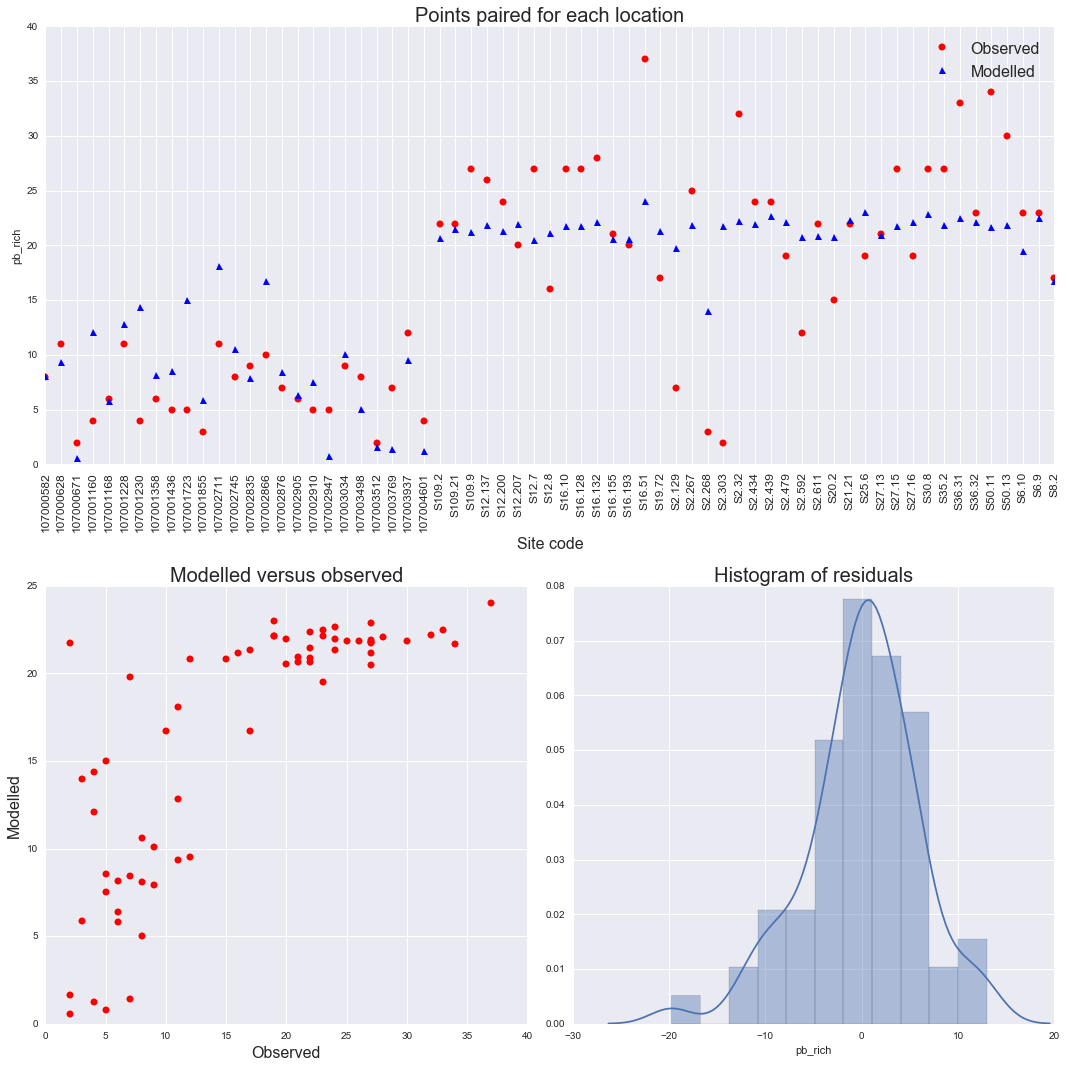

In [27]:
# EL regression
res = mlr(pb1_df, exp_vars, resp_var, 
          method='el-net', fit_intercept=True, 
          kcv=3, normalize=False)
res

Based on the cross-validation $r^2$, the elastic net approach has achieved a slight improvement compared to ridge regression, but it's still not a good model. In the optimum parameter set, the $L_1$ ration has been set to 0.5, meaning that the $L_1$ and $L_2$ penalties have both been assigned equal weight. The imfluence of the $L_1$ penalty is also clearly visible - as expected, many of the model coefficients have been set to zero (no just made small), which emphasisies the "feature selection" component offered by this regression scheme. 

The only coefficient with statistical significance is conductivity and its parameter value - and the overall model performance - are not dramatically different to the results using chemistry variables alone. This is strongly suggesting that my hydrological indicators have no explanatory power and we should perhaps try some different metrics.

As a last confirmation step, let's try a model using *only* the hydrological indicators as the explanatory variables. We'll go straight to the elastic net method as I'm pretty sure OLS won't work here.

### 7.5. PB richness against hydrology (Elastic Net)

Mean r2 from 3-fold CV: -11.287

r2 (based on the calibration data i.e. meaningless!): 0.0

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

Elastic net alpha: 525.320236686
Elastic net L1 ratio: 0.5



,effect,error,signif
mean,0.0,0.002111,False
m01,0.0,0.167842,False
m02,0.0,0.110459,False
m03,-0.0,0.473945,False
m04,0.0,0.230408,False
m05,0.0,0.352987,False
m06,0.0,0.303267,False
m07,0.0,0.292902,False
m08,0.0,0.292723,False
m09,0.0,0.419274,False


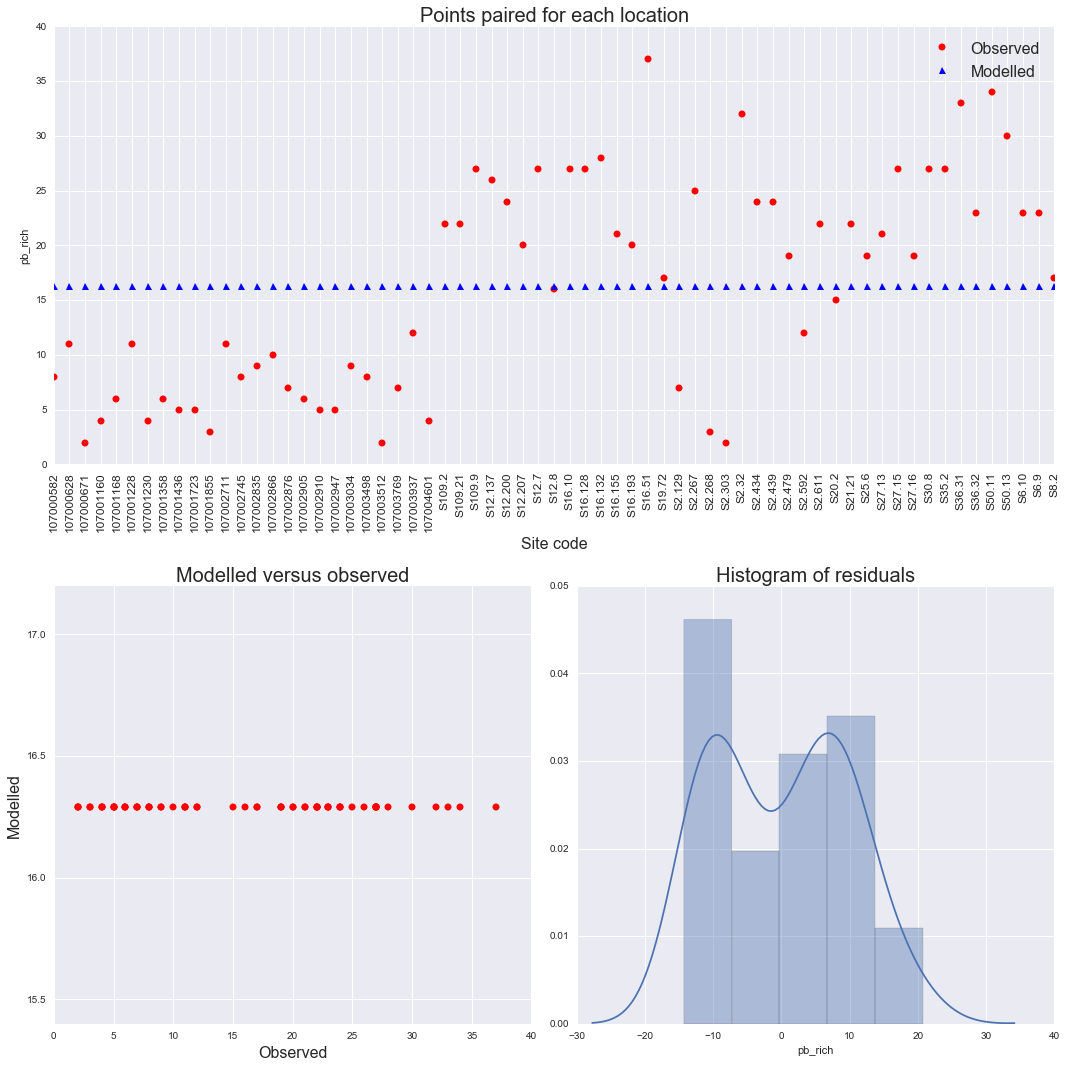

In [28]:
# Lists of explan and resp vars
exp_vars = ['mean', 'm01', 'm02', 'm03', 'm04', 'm05', 'm06',
            'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'min', 'p05', 'p25',
            'p50', 'p75', 'p95', 'max', 'range', 'iqr', 'range90', 'cv',
            'days_to_max', 'days_to_min', 'days_to_p05', 'days_to_p95',
            'ma_07_max', 'ma_07_min', 'ma_30_max', 'ma_30_min', 'ma_90_max',
            'ma_90_min', 'revs_per_yr']

resp_var = 'pb_rich'

# Elastic Net regression
res = mlr(pb1_df, exp_vars, resp_var, 
          method='el-net', fit_intercept=True, 
          kcv=3, normalize=False)
res

Interesting! When we feed in just the hydrological parameters, the elastic net ends up setting all the model coefficients to zero and just predicting an intercept (equal to the mean of the data points). The calibration $r^2$ is therefore equal to zero, because the predictions are *exactly* equal to the mean. It's not what I was hoping for, but it is actually a useful result, as it confirms that my current selection of hydrologic parameters have no relationship whatsoever with the PB richness data.

If I'm going to make any progress I'll need to revise my hydrological metrics, perhaps by considering shorter time periods e.g. what happened immediately before sampling, say, during in the previous two or three months?

## 8. Summary

 * I've calculated some new hydrological metrics which are more relevant to our data than those calculated using the IHA approach. <br><br>
 
 * PB species richness at the German sites can be at least partially explained in terms of water chemistry, but in Norway there is considerable variation in species richness and comparatively little variation in chemistry. <br><br>
 
 * The PB diversity in Norway must therefore be controlled by other factors. The most obvious candidate would be hydrology but, unfortunately, the Norwegian PB don't seem very impressed with my choice of hydrological indicators so far. <br><br>
 
 * Regularised multiple linear regression offers quite a promising way of investigating this kind of data, but before going any further it looks as though we should revisit the hydrological indicators themselves to see if we canm identify some quantities that are more relevant. <br><br>
 
 * For my next try, I'm tempted to focus on the hydrology immediately prior to sampling - perhaps looking at what's happened over the previous two to three months? With a bit of luck, these statistics will be more driectly relevant to the PB, so we might be able to detect some more interesting patterns and relationships. Maybe...